# 1. Preparation

## 1.1. Import Libraries

In [1]:
import os
import re
import string
import warnings
warnings.simplefilter("ignore")

import lightgbm as lgb
import nltk
import numpy as np
import optuna
import pandas as pd
import tensorflow as tf
from imblearn.over_sampling import SMOTE, RandomOverSampler
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from keras.layers import add, concatenate
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from optuna.integration import KerasPruningCallback
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split as tts
from sklearn.utils.class_weight import compute_class_weight as ccw
from tensorflow.keras import Model, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    BatchNormalization,
    Dense,
    Dropout,
    Flatten,
    Input,
    LeakyReLU,
    Rescaling,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import set_random_seed, to_categorical

pd.options.display.max_columns=100
nltk.download('stopwords')

Duplicate key in file PosixPath('/opt/conda/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'), line 786 ('font.family:  IPAexGothic')
Duplicate key in file PosixPath('/opt/conda/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'), line 787 ('figure.figsize: 16.4, 12.3')
Duplicate key in file PosixPath('/opt/conda/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'), line 788 ('figure.dpi: 150')
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## 1.2. Fetching Data

In [2]:
seed = 0
np.random.seed(seed)
set_random_seed(seed)

train_df = pd.read_csv("../input/train.csv", index_col="text_id")
X_train = train_df.full_text
cols = [col for col in train_df.columns if col != "full_text"]
y_train = train_df[cols]
X_test = pd.read_csv("../input/test.csv", index_col="text_id").full_text
X_test_idx = X_test.index

## 1.3. Custom Fanctions

memo
encoding, onebyone_wrapper, kfold, oversampling, building_model, check_results
optuna, optunaresult, predict

In [3]:
@tf.autograph.experimental.do_not_convert
def MCRMSE_keras(y_true, y_pred):
    return tf.reduce_mean(tf.reduce_mean(tf.square(y_true - y_pred), axis=1))

In [ ]:
class BuildModel:
    
    def __init__(self, X_train = X_train, y_train = y_train, X_test = X_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        
    def execution(n_components = 500, n_splits = 4):
        
        
    def encodingX(n_components = 500):
        train_idx = self.X_train.index
        test_idx = self.X_test.index

        X_train = self.X_train.str.lower().replace(re.compile(r'[\n\r\t]'), ' ', regex=True)
        X_test = self.X_test.str.lower().replace(re.compile(r'[\n\r\t]'), ' ', regex=True)

        stop_words = stopwords.words('english')
        remove_stopwords = lambda ls: [" ".join([word for word in l.split() if not word in stop_words]) for l in ls] 
        X_train = remove_stopwords(X_train)
        X_test = remove_stopwords(X_test)

        X_train = [re.sub("[%s]" % re.escape(string.punctuation), "", t) for t in X_train]
        X_test = [re.sub("[%s]" % re.escape(string.punctuation), "", t) for t in X_test]

        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(X_train)
        X_train = tokenizer.texts_to_matrix(X_train, "tfidf")
        X_test = tokenizer.texts_to_matrix(X_test, "tfidf")

        pca = PCA(n_components=n_components, whiten=True, random_state=seed)
        X_train = pd.DataFrame(pca.fit_transform(X_train), index=train_idx)
        X_test = pd.DataFrame(pca.transform(X_test), index=test_idx)
        return X_train, X_test

In [4]:
def encodingX(X_train = X_train, X_test = X_test, n_components = 500):
    train_idx = X_train.index
    test_idx = X_test.index

    X_train = X_train.str.lower().replace(re.compile(r'[\n\r\t]'), ' ', regex=True)
    X_test = X_test.str.lower().replace(re.compile(r'[\n\r\t]'), ' ', regex=True)
    
    stop_words = stopwords.words('english')
    remove_stopwords = lambda ls: [" ".join([word for word in l.split() if not word in stop_words]) for l in ls] 
    X_train = remove_stopwords(X_train)
    X_test = remove_stopwords(X_test)

    X_train = [re.sub("[%s]" % re.escape(string.punctuation), "", t) for t in X_train]
    X_test = [re.sub("[%s]" % re.escape(string.punctuation), "", t) for t in X_test]
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)
    X_train = tokenizer.texts_to_matrix(X_train, "tfidf")
    X_test = tokenizer.texts_to_matrix(X_test, "tfidf")

    pca = PCA(n_components=n_components, whiten=True, random_state=seed)
    X_train = pd.DataFrame(pca.fit_transform(X_train), index=train_idx)
    X_test = pd.DataFrame(pca.transform(X_test), index=test_idx)
    return X_train, X_test

def exec_one_by_one():
    

In [99]:
def building_keras_model(X_train, y_train, params, X_val = None, y_val = None):
    X_train, y_train = OverSampling(X_train, y_train)
    model = Sequential()
    for i in range(1, params["NLayers"]+1):
        if params[f"BatchNorm_l{i}"]:
            model.add(BatchNormalization())
        if params[f"Activation_l{i}"] == "lrelu":
            params[f"Activation_l{i}"] = LeakyReLU(alpha=.1)
        
        if i == 1:
            model.add(Dense(params[f"Units_l{i}"], input_dim=X_train.shape[1], activation=params[f"Activation_l{i}"]))
        else:
            model.add(Dense(params[f"Units_l{i}"], activation=params[f"Activation_l{i}"]))
            
        if params[f"Dropout_l{i}"]:
            model.add(Dropout(.3))

    if params["Rescaling"]:
        model.add(Dense(1, activation="sigmoid"))
        model.add(Rescaling(4, offset=1))
    else:
        model.add(Dense(1, activation="linear"))
        
    optimizer = optimizers.Adam(learning_rate=params["LearningRate"], amsgrad=True)
    model.compile(loss=MCRMSE_keras, optimizer=optimizer, metrics=[MCRMSE_keras])
    
    callbacks = [EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)]
    if not params["Pruner"] is None:
        callbacks += [params["Pruner"]]
    
    model.fit(X_train, y_train,# validation_data = (X_val, y_val),
              batch_size=params["BatchSize"], epochs=10,
              workers=8, use_multiprocessing=True, verbose=1, callbacks=callbacks)
    
    if not X_val is None:
        evaluation = model.evaluate(X_val, y_val, verbose=0)
        return model, evaluation
    else:
        return model
    
def optuna_params(trial):
    params = {
        "n_splits": 4,
        "NLayers": trial.suggest_int("NLayers", 7, 20),
        "LearningRate": trial.suggest_uniform("LearningRate", .0005, .01),
        "BatchSize": 2**3,
        'Rescaling': False,#trial.suggest_categorical('Rescaling', [True, False]) 
        "Pruner": None #KerasPruningCallback(trial, "val_acc"),
        }

    for i in range(1, params["NLayers"]+1):
        params[f"BatchNorm_l{i}"] = trial.suggest_categorical(f'BatchNorm_l{i}', [True, False])
        params[f"Units_l{i}"] = int(trial.suggest_uniform(f"Units_l{i}", 300, 2000))
        activation = trial.suggest_categorical(f'Activation_l{i}', ['relu', "lrelu", "softplus", "softsign"])
        if activation == "lrelu":
            activation = LeakyReLU(alpha=.1)
        params[f'Activation_l{i}'] = activation
        params[f'Dropout_l{i}'] = trial.suggest_categorical(f'Dropout_l{i}', [True, False]) 
    return params

def prediction(X_test, model):
    return pd.DataFrame(model.predict(X_test), columns=cols, index=X_test_idx)

def KFolds(X_train, y_train, n_splits = 4):
    mskf = MultilabelStratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    X_trains = []
    X_vals = []
    y_trains = []
    y_vals = []
    
    for train_idx, val_idx in mskf.split(X_train, y_train):
        X_trains.append(X_train.iloc[train_idx,:])
        X_vals.append(X_train.iloc[val_idx,:])
        y_trains.append(y_train.iloc[train_idx,:])
        y_vals.append(y_train.iloc[val_idx,:])
        
    return X_trains, X_vals, y_trains, y_vals

def validating_and_pred4nextLevel(X_train, y_train, params, n_splits = 4):
    preds = {col: [] for col in cols}
    evals = {col: [] for col in cols}
    for col in cols:
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
        for train_idx, val_idx in skf.split(X_train, y_train):
            X_val = X_train.iloc[val_idx,:]
            y_val = y_train.iloc[val_idx,:]
            X_train = X_train.iloc[train_idx,:]
            y_train = y_train.iloc[train_idx,:]
            model, evaluation = building_keras_model(X_train, y_train, params, X_val, y_val)
            evals[col] += [evaluation]
            preds[col] += [model.predict(X_val)]
        evals[col] = np.mean(evals[col])
        preds[col] = pd.DataFrame(np.concatenate(preds[col], axis=1), index=X_val.index, columns=[col])
    evals = pd.DataFrame(evals)
    preds = pd.concat(list(preds.values()), axis=1)
    return evals, preds

def objective(trial):
    tf.keras.backend.clear_session()
    X_train_enc, X_test_enc = encodingX()
    params = optuna_params(trial)
    evals, preds = validating_and_pred4nextLevel(X_train_enc, y_train, params, params["n_splits"])
    return evals

def study_result(study_name):
    study = optuna.load_study(study_name=study_name, storage=storage)
    bts = []
    for bt in study.best_trials:
        values = bt.values or [0]
        values = [bt.number] + values + [bt.datetime_complete - bt.datetime_start] + list(bt.params.values())
        bts.append(pd.DataFrame([values], columns = ["number", "MCRMSE", "exec_time"] + list(bt.params.keys())))
        res = pd.concat(bts, axis=0, ignore_index=True).sort_values("MCRMSE")
    return res

def OverSampling(X_train, y_train):
    X_idx = list(X_train.index)
    
    maximum = int(len(y_train) * 1.5)
    agg = y_train.value_counts()
    mean = int(agg.mean())
    agg_ltm = agg < mean
    strategy_value = (maximum - (agg[agg>=mean]).sum()) // (agg_ltm).sum()
    add_value = (maximum - (agg[agg>=mean]).sum()) % (agg_ltm).sum()
    sampling_strategy = {str(k): strategy_value + add_value if k == agg[agg_ltm].index[0] else strategy_value for k in agg_ltm[agg_ltm].index}
    X_train, y_train = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=seed).fit_resample(X_train, y_train.astype(str))
    idx = X_idx + list(X_train.index[len(X_idx):])
    X_train.index = idx
    y_train.index = idx
    y_train = y_train.astype(np.float64)
    return X_train, y_train

def concat_models(X_train, y_train, models, X_val=None, y_val=None):
    model = concatenate([model.output for model in models])
    model = Dense(500, activation="relu")(model)
    model = Dense(1000, activation="relu")(model)
    model = Dense(500, activation="relu")(model)
    model = Dense(y_train.iloc[:,:2].shape[1], activation="linear")(model)
    model = Model([model.input for model in models], model)
    
    optimizer = optimizers.Adam(amsgrad=True)
    model.compile(loss=MCRMSE_keras, optimizer=optimizer, metrics=[MCRMSE_keras])
    callbacks = [EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)]
    model.fit([X_train, X_train], y_train.iloc[:,:2],# validation_data = (X_val, y_val),
              batch_size=2**3, epochs=10,
              workers=8, use_multiprocessing=True, verbose=1, callbacks=callbacks)
    
    if not X_val is None:
        evaluation = model.evaluate(X_val, y_val, verbose=0)
        return model, evaluation
    else:
        return model

# 2. Building Models

## 2.0. set the variables

In [6]:
storage = 'mysql+pymysql://iori:'+os.environ["MySQL_PASSWORD"]+'@'+os.environ["MySQL_IP"]+":3306/kaggleELL?charset=utf8mb4"
directions = ["minimize"]

## 2.1. keras1

In [ ]:
study_name = "keras1"

keras_study = optuna.create_study(study_name=study_name, directions=directions,# pruner=optuna.pruners.MedianPruner(), 
                                  storage=storage, load_if_exists=True)
keras_study.optimize(objective, n_trials=50, gc_after_trial=True)
res = study_result(study_name)
res

In [101]:
models = []

res = study_result("keras1")
params = {k:v for k,v in zip(res.columns, res.values[0])} | {"BatchSize": 2**3, "Rescaling": False, "Pruner": None}
X_train_enc, X_test_enc = encodingX()
for col in cols[:2]:
    models.append(building_keras_model(X_train_enc, y_train[col], params))
model = concat_models(X_train_enc, y_train, models, X_val=None, y_val=None)
model.predict([X_test_enc] * 2)

Epoch 1/10
732/734 [============================>.] - ETA: 0s - loss: 2.0690 - MCRMSE_keras: 2.0690WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 21s 19ms/step - loss: 2.0671 - MCRMSE_keras: 2.0650
Epoch 2/10
733/734 [============================>.] - ETA: 0s - loss: 1.0371 - MCRMSE_keras: 1.0371WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 1.0370 - MCRMSE_keras: 1.0366
Epoch 3/10
734/734 [==============================] - ETA: 0s - loss: 0.9101 - MCRMSE_keras: 0.9092WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 0.9101 - MCRMSE_keras: 0.9092
Epoch 4/10
734/734 [==============================] - ETA: 0s - loss: 0.7559 - MCRMSE_keras: 0.7553WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 0.7559 - MCRMSE_keras: 0.7553
Epoch 5/10
734/734 [==============================] - ETA: 0s - loss: 0.6790 - MCRMSE_keras: 0.6785WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 0.6790 - MCRMSE_keras: 0.6785
Epoch 6/10
733/734 [============================>.] - ETA: 0s - loss: 0.6644 - MCRMSE_keras: 0.6644WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 20ms/step - loss: 0.6645 - MCRMSE_keras: 0.6647
Epoch 7/10
734/734 [==============================] - ETA: 0s - loss: 0.6254 - MCRMSE_keras: 0.6275WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 0.6254 - MCRMSE_keras: 0.6275
Epoch 8/10
732/734 [============================>.] - ETA: 0s - loss: 0.5812 - MCRMSE_keras: 0.5812WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 0.5805 - MCRMSE_keras: 0.5800
Epoch 9/10
734/734 [==============================] - ETA: 0s - loss: 0.5979 - MCRMSE_keras: 0.5993WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 0.5979 - MCRMSE_keras: 0.5993
Epoch 10/10
732/734 [============================>.] - ETA: 0s - loss: 0.8573 - MCRMSE_keras: 0.8573WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 0.8565 - MCRMSE_keras: 0.8561
Epoch 1/10
734/734 [==============================] - ETA: 0s - loss: 2.1981 - MCRMSE_keras: 2.1964WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 22s 19ms/step - loss: 2.1981 - MCRMSE_keras: 2.1964
Epoch 2/10
734/734 [==============================] - ETA: 0s - loss: 1.2070 - MCRMSE_keras: 1.2069WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 1.2070 - MCRMSE_keras: 1.2069
Epoch 3/10
734/734 [==============================] - ETA: 0s - loss: 0.9675 - MCRMSE_keras: 0.9679WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 0.9675 - MCRMSE_keras: 0.9679
Epoch 4/10
733/734 [============================>.] - ETA: 0s - loss: 0.8783 - MCRMSE_keras: 0.8783WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 0.8780 - MCRMSE_keras: 0.8773
Epoch 5/10
733/734 [============================>.] - ETA: 0s - loss: 0.7701 - MCRMSE_keras: 0.7701WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 0.7700 - MCRMSE_keras: 0.7699
Epoch 6/10
733/734 [============================>.] - ETA: 0s - loss: 0.6762 - MCRMSE_keras: 0.6762WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 0.6763 - MCRMSE_keras: 0.6768
Epoch 7/10
734/734 [==============================] - ETA: 0s - loss: 0.6652 - MCRMSE_keras: 0.6671WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 0.6652 - MCRMSE_keras: 0.6671
Epoch 8/10
732/734 [============================>.] - ETA: 0s - loss: 0.6010 - MCRMSE_keras: 0.6010WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 20ms/step - loss: 0.6001 - MCRMSE_keras: 0.5997
Epoch 9/10
732/734 [============================>.] - ETA: 0s - loss: 0.5927 - MCRMSE_keras: 0.5927WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 15s 20ms/step - loss: 0.5934 - MCRMSE_keras: 0.5939
Epoch 10/10
734/734 [==============================] - ETA: 0s - loss: 0.5836 - MCRMSE_keras: 0.5842WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 0.5836 - MCRMSE_keras: 0.5842
Epoch 1/10
489/489 [==============================] - ETA: 0s - loss: 0.5669 - MCRMSE_keras: 0.5669WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 30s 30ms/step - loss: 0.5669 - MCRMSE_keras: 0.5669
Epoch 2/10
488/489 [============================>.] - ETA: 0s - loss: 0.4833 - MCRMSE_keras: 0.4833WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.4831 - MCRMSE_keras: 0.4831
Epoch 3/10
489/489 [==============================] - ETA: 0s - loss: 0.4757 - MCRMSE_keras: 0.4757WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.4757 - MCRMSE_keras: 0.4757
Epoch 4/10
488/489 [============================>.] - ETA: 0s - loss: 0.4405 - MCRMSE_keras: 0.4405WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.4408 - MCRMSE_keras: 0.4408
Epoch 5/10
488/489 [============================>.] - ETA: 0s - loss: 0.4200 - MCRMSE_keras: 0.4200WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.4196 - MCRMSE_keras: 0.4195
Epoch 6/10
488/489 [============================>.] - ETA: 0s - loss: 0.4142 - MCRMSE_keras: 0.4142WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.4142 - MCRMSE_keras: 0.4141
Epoch 7/10
489/489 [==============================] - ETA: 0s - loss: 0.4139 - MCRMSE_keras: 0.4139WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.4139 - MCRMSE_keras: 0.4139
Epoch 8/10
489/489 [==============================] - ETA: 0s - loss: 0.4126 - MCRMSE_keras: 0.4126WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.4126 - MCRMSE_keras: 0.4126
Epoch 9/10
489/489 [==============================] - ETA: 0s - loss: 0.4151 - MCRMSE_keras: 0.4151WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 31ms/step - loss: 0.4151 - MCRMSE_keras: 0.4151
Epoch 10/10
489/489 [==============================] - ETA: 0s - loss: 0.3978 - MCRMSE_keras: 0.3977WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


1/1 [==============================] - 0s 483ms/step


array([[3.2621105, 3.18507  ],
       [2.7542586, 2.7154098],
       [3.2621033, 3.1850975]], dtype=float32)

In [25]:
model = concat_models(X_train_enc, y_train, models, X_val=None, y_val=None)
model.predict(X_test_enc)

Epoch 1/10
489/489 [==============================] - ETA: 0s - loss: 0.4201 - MCRMSE_keras: 0.4201WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 30s 30ms/step - loss: 0.4201 - MCRMSE_keras: 0.4201
Epoch 2/10
489/489 [==============================] - ETA: 0s - loss: 0.3656 - MCRMSE_keras: 0.3656WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.3656 - MCRMSE_keras: 0.3656
Epoch 3/10
489/489 [==============================] - ETA: 0s - loss: 0.4238 - MCRMSE_keras: 0.4238WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.4238 - MCRMSE_keras: 0.4238
Epoch 4/10
488/489 [============================>.] - ETA: 0s - loss: 0.4102 - MCRMSE_keras: 0.4102WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.4107 - MCRMSE_keras: 0.4108
Epoch 5/10
489/489 [==============================] - ETA: 0s - loss: 0.4056 - MCRMSE_keras: 0.4055WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.4056 - MCRMSE_keras: 0.4055
Epoch 6/10
489/489 [==============================] - ETA: 0s - loss: 0.4292 - MCRMSE_keras: 0.4292WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.4292 - MCRMSE_keras: 0.4292
Epoch 7/10
489/489 [==============================] - ETA: 0s - loss: 0.4210 - MCRMSE_keras: 0.4210WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 31ms/step - loss: 0.4210 - MCRMSE_keras: 0.4210
Epoch 8/10
489/489 [==============================] - ETA: 0s - loss: 0.4084 - MCRMSE_keras: 0.4085WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.4084 - MCRMSE_keras: 0.4085
Epoch 9/10
489/489 [==============================] - ETA: 0s - loss: 0.4048 - MCRMSE_keras: 0.4047WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.4048 - MCRMSE_keras: 0.4047
Epoch 10/10
489/489 [==============================] - ETA: 0s - loss: 0.3995 - MCRMSE_keras: 0.3995WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.3995 - MCRMSE_keras: 0.3995


ValueError: in user code:

    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_3" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 500) dtype=float64>]


In [27]:
model.predict([X_test_enc, X_test_enc])

1/1 [==============================] - 1s 501ms/step


array([[2.945384 , 2.882789 ],
       [2.945384 , 2.882789 ],
       [2.9453735, 2.8827846]], dtype=float32)

In [26]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 batch_normalization_input (Inp  [(None, 500)]       0           []                               
 utLayer)                                                                                         
                                                                                                  
 batch_normalization_10_input (  [(None, 500)]       0           []                               
 InputLayer)                                                                                      
                                                                                                  
 batch_normalization (BatchNorm  (None, 500)         2000        ['batch_normalization_input[0][0]
 alization)                                                      ']                         

cohesion 1.0


NameError: name 'pred' is not defined

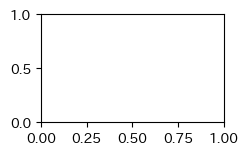

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
count = 1
fig = plt.figure(figsize=(25,10))
for col in cols:
    for score in sorted(y_train[col].unique()):
        ax = fig.add_subplot(6, 9, count)
        print(col, score)
        data = pd.concat([y_train[col], pred[col]], axis=1)
        data.columns = ["true", "pred"]
        sns.distplot(data[data["true"]==score].pred, ax = ax, kde=False);
        ax.set_xlabel(score);
        ax.set_xlim([1,5]);
        ax.set_title(col+str(score));
        plt.tight_layout()
        fig.show();
        count += 1

In [15]:
preds = [keras1_pred, keras2_pred, keras3_pred, keras4_pred, lgb1_pred, lgb2_pred]
pred = pd.DataFrame(np.mean(np.array(preds), axis=0), columns=cols, index=X_test_idx)
pred

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
text_id,,,,,,
0000C359D63E,2.767483,2.733454,2.969960,2.808294,2.716757,2.652545
000BAD50D026,3.038738,2.872625,3.037558,2.952971,2.719184,2.952540
00367BB2546B,3.365481,3.267979,3.486429,3.339178,3.286980,3.294214


In [86]:
pred.to_csv("submission.csv", index=True)